In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import scipy

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
# engine.table_names()
Base = automap_base()


# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
measurement=Base.classes.measurement
station=Base.classes.station


In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
# understanding the tables
engine.execute('select * from measurement').fetchall()
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])
print('--------')
columns2=inspector.get_columns('station')
for column in columns2:
    print(column['name'],column['type'])
print('--------')
# engine.execute('select date from measurement').fetchall()

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
--------
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT
--------


2017-08-23
2016-08-23


Text(0.5, 1.0, 'Precipitation in the last 12 months')

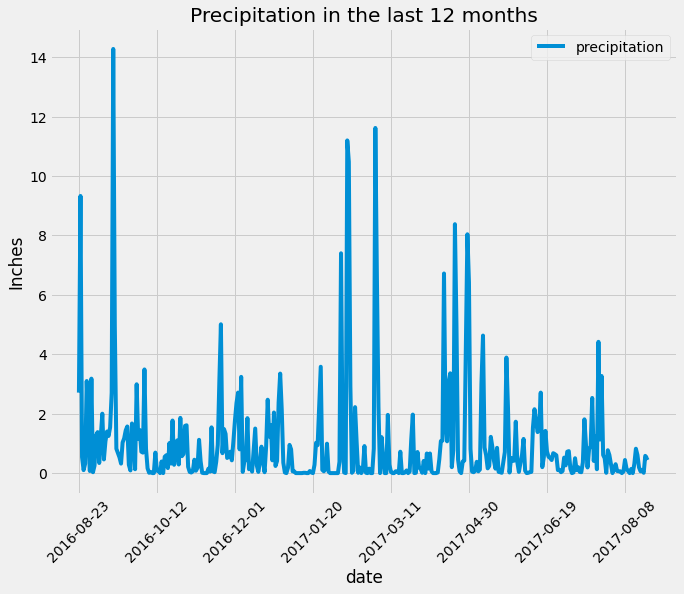

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

latest_date=session.query(measurement.date).order_by(measurement.date.desc()).first()
latest_date=dt.date(2017,8,23)
print(latest_date)

# Calculate the date 1 year ago from the last data point in the database

one_year_ago=latest_date-dt.timedelta(days=365)
print(one_year_ago)

# Perform a query to retrieve the data and precipitation scores

prcp=session.query(measurement.date,measurement.prcp).filter(measurement.date>=one_year_ago).all()

# Save the query results as a Pandas DataFrame and set the index to the date column

prcp_df=pd.DataFrame(prcp).rename(columns = {'prcp': 'precipitation'}).set_index('date')

# Sort the dataframe by date
prcp_df=prcp_df.sort_values(by='date').groupby('date').sum()
# prcp_df.info()
# Use Pandas Plotting with Matplotlib to plot the data

prcp_df.plot(figsize=(10,8),rot=45)
plt.ylabel('Inches')
plt.title('Precipitation in the last 12 months')

In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data

prcp_df.describe()

,precipitation
count,366.000000
mean,0.978907
std,1.776349
min,0.000000
25%,0.052500
50%,0.405000
75%,1.087500
max,14.280000


In [13]:
# Design a query to show how many stations are available in this dataset?

# station_count=len(session.query(station.station).group_by(station.station).all())
# station_count

# to make sure there are the same types of stations in both tables
station_count=len(session.query(measurement.station).group_by(measurement.station).all())
station_count


9

In [14]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_sta=session.query(measurement.station,func.count(measurement.station)).\
group_by(measurement.station).order_by(func.count(measurement.station).desc()).first()

active_sta

('USC00519281', 2772)

In [15]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
sel=[measurement.station,
    func.min(measurement.tobs),
     func.max(measurement.tobs),
     func.avg(measurement.tobs)]
most_active_sta='USC00519281'
station_temp=session.query(*sel).\
filter(measurement.station==most_active_sta).all()

station_temp
print(f'The lowest temperature for {most_active_sta} is {station_temp[0][1]}')
print(f'The highest temperature for {most_active_sta} is {station_temp[0][2]}')
print(f'The average temperature for {most_active_sta} is {station_temp[0][3]}')


The lowest temperature for USC00519281 is 54.0
The highest temperature for USC00519281 is 85.0
The average temperature for USC00519281 is 71.66378066378067


Text(0.5, 1.0, 'Temperature distribution frequency')

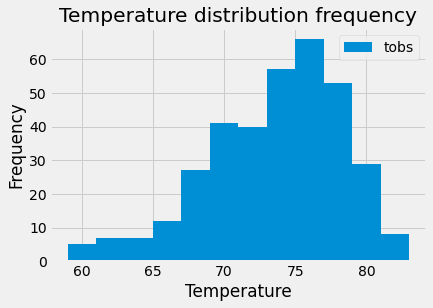

In [16]:
# Choose the station with the highest number of temperature observations.
highest_obs_sta=session.query(measurement.station,func.count(measurement.tobs)).\
group_by(measurement.station).order_by(func.count(measurement.station).desc()).first()
highest_obs_sta
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

last_12_mths=session.query(measurement.date,measurement.tobs).\
filter(measurement.station=='USC00519281').\
filter(measurement.date>=one_year_ago).all()

last_12_mths

last_12_mths_df=pd.DataFrame(last_12_mths)
last_12_mths_df
last_12_mths_df.plot(kind='hist',bins=12)
plt.xlabel('Temperature')
plt.title('Temperature distribution frequency')

## Bonus Challenge Assignment

In [17]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)).\
        filter(measurement.date >= start_date).filter(measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

print(calc_temps('2016-08-23','2017-08-23'))

[(62.0, 69.57142857142857, 74.0)]
[(58.0, 74.59058295964125, 87.0)]


In [18]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

# date=session.query(measurement.date).all()
# date
# prcp_df.index=pd.to_datetime(prcp_df.index,format='%Y-%m-%d')

calc_data=calc_temps(func.datetime(one_year_ago),func.datetime(latest_date))
tmin=calc_data[0][0]
tavg=calc_data[0][1]
tmax=calc_data[0][2]

Text(0, 0.5, 'Temperature')

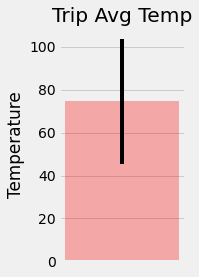

In [19]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


plt.figure(figsize=(2,4))
plt.bar(0,tavg, width=0.4, color='r', alpha=0.3)


plt.errorbar(0,tavg,yerr = tmax - tmin, color='k')
plt.title('Trip Avg Temp')
plt.xticks([])
plt.ylabel('Temperature')

In [31]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

sel=[measurement.station,func.sum(measurement.prcp),station.name,station.latitude,\
     station.longitude,station.elevation]
total_rainfall=session.query(*sel).filter(measurement.date>=one_year_ago).\
filter(measurement.station==station.station).group_by(measurement.station).\
order_by(func.sum(measurement.prcp).desc()).all()

total_rainfall

rainfall_list=[]
station_list=[]
name_list=[]
lat_list=[]
lon_list=[]
elevation_list=[]

for prcp in total_rainfall:
    station_list.append(prcp[0])
    rainfall_list.append(prcp[1])
    name_list.append(prcp[2])
    lat_list.append(prcp[3])
    lon_list.append(prcp[4])
    elevation_list.append(prcp[5])

rainfall_df=pd.DataFrame({
    'Station':station_list,
    'Name':name_list,
    'Rainfall':rainfall_list,
    'Latitude':lat_list,
    'Longitude':lon_list,
    'Elevation':elevation_list
    })

rainfall_df

,Station,Name,Rainfall,Latitude,Longitude,Elevation
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",147.81,21.33310,-157.80250,152.4
1,USC00519281,"WAIHEE 837.5, HI US",70.03,21.45167,-157.84889,32.9
2,USC00513117,"KANEOHE 838.1, HI US",48.51,21.42340,-157.80150,14.6
3,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",38.01,21.33556,-157.71139,19.5
4,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",33.24,21.52130,-157.83740,7.0
5,USC00519397,"WAIKIKI 717.2, HI US",16.09,21.27160,-157.81680,3.0
6,USC00517948,"PEARL CITY, HI US",4.59,21.39340,-157.97510,11.9


In [32]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [53]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date='2017-07-07'
end_date='2017-08-12'
# Use the start and end date to create a range of dates
# start_date_dt=dt.datetime.strptime(start_date,'%Y-%m-%d')
# end_date_dt=dt.datetime.strptime(end_date,'%Y-%m-%d')

date_range=session.query(measurement.date).filter(measurement.date>=start_date).\
filter(measurement.date<=end_date).group_by(measurement.date).all()
date_range

# Stip off the year and save a list of %m-%d strings
date_range_list=[]
for date in date_range:
    date_range_list.append(dt.datetime.strptime(date[0],'%Y-%m-%d'))

new_date_range=[date.strftime('%m-%d')for date in date_range_list]  
new_date_range

# Loop through the list of %m-%d strings and calculate the normals for each date
normals=[]

for date in new_date_range:
    normal_dict={}
    normal_dict['Date']=date
    normal_dict['tmin']=daily_normals(date)[0][0]
    normal_dict['tavg']=daily_normals(date)[0][1]
    normal_dict['tmax']=daily_normals(date)[0][2]
    normals.append(normal_dict)
    
normals

[{'Date': '07-07', 'tmin': 69.0, 'tavg': 74.91071428571429, 'tmax': 82.0},
 {'Date': '07-08', 'tmin': 69.0, 'tavg': 76.08333333333333, 'tmax': 83.0},
 {'Date': '07-09', 'tmin': 68.0, 'tavg': 76.19298245614036, 'tmax': 83.0},
 {'Date': '07-10', 'tmin': 68.0, 'tavg': 75.62068965517241, 'tmax': 82.0},
 {'Date': '07-11', 'tmin': 70.0, 'tavg': 75.78947368421052, 'tmax': 81.0},
 {'Date': '07-12', 'tmin': 67.0, 'tavg': 75.96491228070175, 'tmax': 82.0},
 {'Date': '07-13', 'tmin': 69.0, 'tavg': 76.1896551724138, 'tmax': 81.0},
 {'Date': '07-14', 'tmin': 61.0, 'tavg': 76.2280701754386, 'tmax': 82.0},
 {'Date': '07-15', 'tmin': 68.0, 'tavg': 76.2542372881356, 'tmax': 82.0},
 {'Date': '07-16', 'tmin': 70.0, 'tavg': 76.34482758620689, 'tmax': 83.0},
 {'Date': '07-17', 'tmin': 70.0, 'tavg': 76.30188679245283, 'tmax': 83.0},
 {'Date': '07-18', 'tmin': 72.0, 'tavg': 76.63793103448276, 'tmax': 83.0},
 {'Date': '07-19', 'tmin': 68.0, 'tavg': 75.89090909090909, 'tmax': 83.0},
 {'Date': '07-20', 'tmin': 6

In [55]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
trip_normals=pd.DataFrame(normals).set_index('Date')
trip_normals

,tmin,tavg,tmax
Date,,,
07-07,69.0,74.910714,82.0
07-08,69.0,76.083333,83.0
07-09,68.0,76.192982,83.0
07-10,68.0,75.620690,82.0
07-11,70.0,75.789474,81.0
07-12,67.0,75.964912,82.0
07-13,69.0,76.189655,81.0
07-14,61.0,76.228070,82.0
07-15,68.0,76.254237,82.0


Text(0, 0.5, 'Temperature')

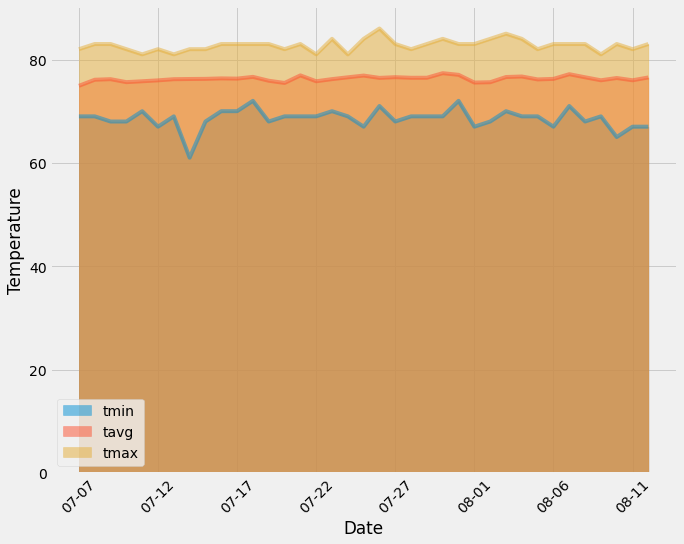

In [59]:
# Plot the daily normals as an area plot with `stacked=False`
trip_normals.plot.area(stacked=False,rot=45,figsize=(10,8))
plt.ylabel('Temperature')

In [72]:
latest_date = session.query(measurement.date).order_by(measurement.date.desc()).first()
latest_date = dt.date(2017, 8, 23)
one_year_ago = latest_date - dt.timedelta(days=365)
active_sta = session.query(measurement.station, func.count(measurement.station)).\
group_by(measurement.station).order_by(func.count(measurement.station).desc()).first()
active_sta
sel = [measurement.date,
           measurement.tobs]
station_temp = session.query(*sel). \
        filter(measurement.station == active_sta[0]).\
filter(measurement.date>=one_year_ago).all()
tob_list=[]
station_temp 
tob_list=[]
for x in station_temp:
    tob_dict={}
    tob_dict['date']=x[0]
    tob_dict['tem']=x[1]
    tob_list.append(tob_dict)
tob_list

[{'date': '2016-08-23', 'tem': 77.0},
 {'date': '2016-08-24', 'tem': 77.0},
 {'date': '2016-08-25', 'tem': 80.0},
 {'date': '2016-08-26', 'tem': 80.0},
 {'date': '2016-08-27', 'tem': 75.0},
 {'date': '2016-08-28', 'tem': 73.0},
 {'date': '2016-08-29', 'tem': 78.0},
 {'date': '2016-08-30', 'tem': 77.0},
 {'date': '2016-08-31', 'tem': 78.0},
 {'date': '2016-09-01', 'tem': 80.0},
 {'date': '2016-09-02', 'tem': 80.0},
 {'date': '2016-09-03', 'tem': 78.0},
 {'date': '2016-09-04', 'tem': 78.0},
 {'date': '2016-09-05', 'tem': 78.0},
 {'date': '2016-09-06', 'tem': 73.0},
 {'date': '2016-09-07', 'tem': 74.0},
 {'date': '2016-09-08', 'tem': 80.0},
 {'date': '2016-09-09', 'tem': 79.0},
 {'date': '2016-09-10', 'tem': 77.0},
 {'date': '2016-09-11', 'tem': 80.0},
 {'date': '2016-09-12', 'tem': 76.0},
 {'date': '2016-09-13', 'tem': 79.0},
 {'date': '2016-09-14', 'tem': 75.0},
 {'date': '2016-09-15', 'tem': 79.0},
 {'date': '2016-09-16', 'tem': 78.0},
 {'date': '2016-09-17', 'tem': 79.0},
 {'date': '2

In [84]:
startdate=input('Date?')
start_date=dt.datetime.strptime(startdate, '%Y-%m-%d').date()

result=session.query(func.min(measurement.tobs), func.avg(measurement.tobs),\
                     func.max(measurement.tobs)).\
filter(measurement.date >= start_date).all()

result

Date?2017-01-01


[(58.0, 74.14387974230493, 87.0)]

In [92]:
startdate=input('Date?')
start_date=dt.datetime.strptime(startdate,'%Y-%m-%d').date()
result=session.query(measurement.date, func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)).\
        filter(func.strftime('%Y-%m-%d',measurement.date) >= start_date).all()
result_list = []
for x in result:
    result_dict = {}
    result_dict['date'] = x[0]
    result_dict['tmin'] = x[1]
    result_dict['tavg']=x[2]
    result_dict['tmax']=x[3]
    result_list.append(result_dict)

result_list


Date?2017-07-07


[{'date': '2017-08-19', 'tmin': 69.0, 'tavg': 78.61904761904762, 'tmax': 85.0}]

In [100]:
latest_date = session.query(measurement.date).order_by(measurement.date.desc()).first()
start_date=dt.datetime.strptime(startdate, '%Y-%m-%d').date()
result=session.query(func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)).\
    filter(measurement.date >= start_date).all()
result

[(69.0, 78.61904761904762, 85.0)]

In [103]:
startdate=input('Date?')
start_date=dt.datetime.strptime(startdate,'%Y%m%d').date()
end_date=dt.datetime.strptime(enddate,'%Y%m%d').strptime('%Y-%m-%d').date()

Date?20170701


ValueError: time data '20170701' does not match format '%Y-%m-%d'